In [10]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
#Генерация данных для построения модели на базе известной зависимости
def data_generation(x_size=200, W=np.array([-20,-10, 0.5])):
    x0 = np.ones(x_size+1)
    x1 = np.linspace(0, 0.1 * x_size , x_size+1)
    x2 = x1**2
    X = np.vstack([x0,x1,x2])
    y = np.array([int(random.gauss(0, 10)) + i for i in np.dot(W, X)])
    
    return W, X, y

W, X, y = data_generation()
#Графическое отображение данных
plt.figure(figsize=(10,10))
plt.scatter(np.linspace(0, 0.1 * 200 , 201), y, label='Зашумленные Наблюдения', c='b')
plt.plot(np.linspace(0, 0.1 * 200 , 201), X.T @ W, label='Незашумленные данные', c='g')
plt.legend()

In [686]:
# Сренеквадраичное отколонение
mse_err = lambda y, y_pred : sum((y - y_pred) ** 2) / len(y)
#Нормализация
norm = lambda ar: np.array([[(j - i.min())/i.max() for j in i] for i in ar])
#Стандартизация
stand = lambda ar: np.array([(i - i.mean())/i.std() for i in ar])

In [850]:
#Данные урока

X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]])

y = np.array([45, 55, 50, 59, 65, 35, 75, 80, 50, 60])


In [851]:
X_norm = np.vstack([X[0],norm(X[1:])])
X_stand = np.vstack([X[0],stand(X[1:])])

In [852]:
def gradient_boosting(X, y, alpha=0.01, tolerance=1e-5, check_fr=10000, L2=1e-4, L1=0):
    
    W_pred = np.ones(X.shape[0])
    i, n,  = 0, len(y)
    mse_prev, mse_last = 3 * tolerance, tolerance
    
    while mse_prev - mse_last > tolerance:
        i += 1
        if i % check_fr == 0: mse_prev = mse_last
        # расчет градиента
        Wg = 2 / n * (W_pred @ X - y) @ X.T 
        # Добавление l2 регуяризации
        Wg += L2 * np.sum(W_pred)
        # Добавление l1 регуяризации
        Wg += L1 * np.sum(W_pred)
        W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(X.T @ W_pred, y)

    #print('Кол-во итераций:', i, '\nВеса признаков: ', W_pred, '\nMSE модели:', mse_err(X.T @ W_pred, y))
    return W_pred

In [853]:
def s_gradient_boosting(X, y, qty_in_batch=5, alpha=0.01, tolerance=1e-5, L2=1e-4, L1=0, check_fr=1000):
    
    W_pred = np.ones(X.shape[0])
    i, n, iter_improve = 0, len(y), 1
    mse_prev, mse_last = 1, 0
    
    n_batch = (n // qty_in_batch + 1) if (n % qty_in_batch) else (n // qty_in_batch)
    print (n_batch)
    while (mse_prev - mse_last) > tolerance:
        i += 1
        if i % check_fr == 0:
            mse_prev = mse_last
        for b in range(n_batch):
            start_ = qty_in_batch * b
            end_ = qty_in_batch * (b + 1)
            X_tmp = X[:, start_:end_]
            y_tmp = y[start_:end_]
            Wg = 2 / n * (W_pred @ X_tmp - y_tmp) @ X_tmp.T
            Wg += L2 * np.sum(W_pred)
            W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(W_pred @ X_tmp, y_tmp)
            #print(i, W_pred, mse_err(W_pred @ X_tmp, y_tmp))
    
    print('Кол-во итераций:', i, '\nВеса признаков: ', W_pred, '\nMSE модели:', mse_err(X.T @ W_pred, y))
    return W_pred

# Задание 2.1. Построение зависимости W от коэффициента L2

In [910]:
%%time

L2_plot_data = pd.DataFrame(columns=['L2']+['W'+str(i) for i in range(X.shape[0])])
    
for i in np.linspace(0, 1, 501):
    L2_plot_data.loc[L2_plot_data.shape[0]] = [i] + list(gradient_boosting(X_stand, y, alpha=0.01, L2=i))

Wall time: 1min 44s


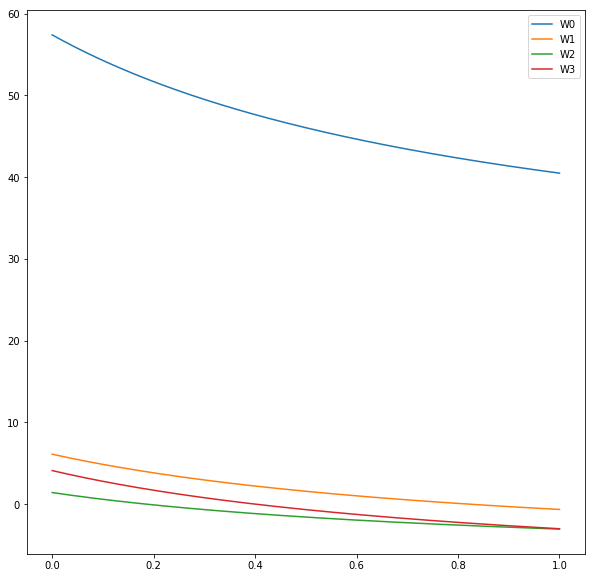

In [911]:


plt.figure(figsize=(10,10))
for col in L2_plot_data.loc[:,'W0':]:
    plt.plot(L2_plot_data['L2'], L2_plot_data[col], label=col)

plt.legend()
plt.show()


# Задание 2.2 
## Можно ли к одному и тому же признаку применить сразу и нормализацию, и стандартизацию?





In [ ]:
Применение стандартизации и нормализации одновременно не имеет смысла т.к. нормализация подразумеевает приведение к диапазону от 0-1, а стандартизация центрирует признаки вокруг нуля как в плюс так и в минус

# Задание 2.3
## Реализовать L1 регуляризацию

In [913]:
def gradient_boosting(X, y, alpha=0.01, tolerance=1e-5, check_fr=10000, L2=1e-4, L1=1e-4):
    
    W_pred = np.ones(X.shape[0])
    i, n,  = 0, len(y)
    mse_prev, mse_last = 3 * tolerance, tolerance
    
    while mse_prev - mse_last > tolerance:
        i += 1
        if i % check_fr == 0: mse_prev = mse_last
        # расчет градиента
        Wg = 2 / n * (W_pred @ X - y) @ X.T 
        # Добавление l2 регуяризации
        Wg += L2 * np.sum(W_pred)
        # Добавление l1 регуяризации
        Wg += L1 * np.sign(W_pred)
        W_pred -= alpha * Wg
        
        if i % check_fr == 0:
            mse_last = mse_err(X.T @ W_pred, y)

    #print('Кол-во итераций:', i, '\nВеса признаков: ', W_pred, '\nMSE модели:', mse_err(X.T @ W_pred, y))
    return W_pred

## Наработки

In [836]:
%%time
#Метод наименьших квадратов
W_mnk = np.linalg.inv(np.dot(X_stand, X_stand.T)) @ X_stand @ y
W_mnk, mse_err(X_stand.T @ W_mnk, y)
print('\nВеса признаков: ', W_mnk, '\nMSE модели:', mse_err(X_stand.T @ W_mnk, y))


Веса признаков:  [57.4         6.12241513  1.42846588  4.11637116] 
MSE модели: 39.777746035558316
Wall time: 15 ms


In [ ]:
W_pred = gradient_boosting(X_stand, y, alpha=0.0001)


plt.figure(figsize=(10,10))

plt.scatter(x1, y, label='Наблюдения', c='b')
plt.plot(x1, X.T @ W, label='Незашумленные данные, MSE ' + str(round(mse_err(X.T @ W, y),4)), c='g')
plt.plot(x1, X_stand.T @ W_pred, label='Прогноз методом градиентного бустинга, MSE ' + str(round(mse_err(X.T @ W_pred, y),4)), c='r')
plt.plot(x1, X.T @ W_mnk, label='Прогноз методом наименьших квадратов, MSE ' + str(round(mse_err(X.T @ W_mnk, y),4)), c='y')
plt.legend()
plt.show()